In [2]:
!python --version

Python 3.11.12


In [3]:
!pip install pandas==2.0.3
!pip install numpy==1.23.5
!pip install matplotlib==3.7.1
!pip install statsmodels==0.14.0
!pip install scikit-learn==1.2.2
!pip install tensorflow==2.12.0
!pip install pmdarima==2.0.4


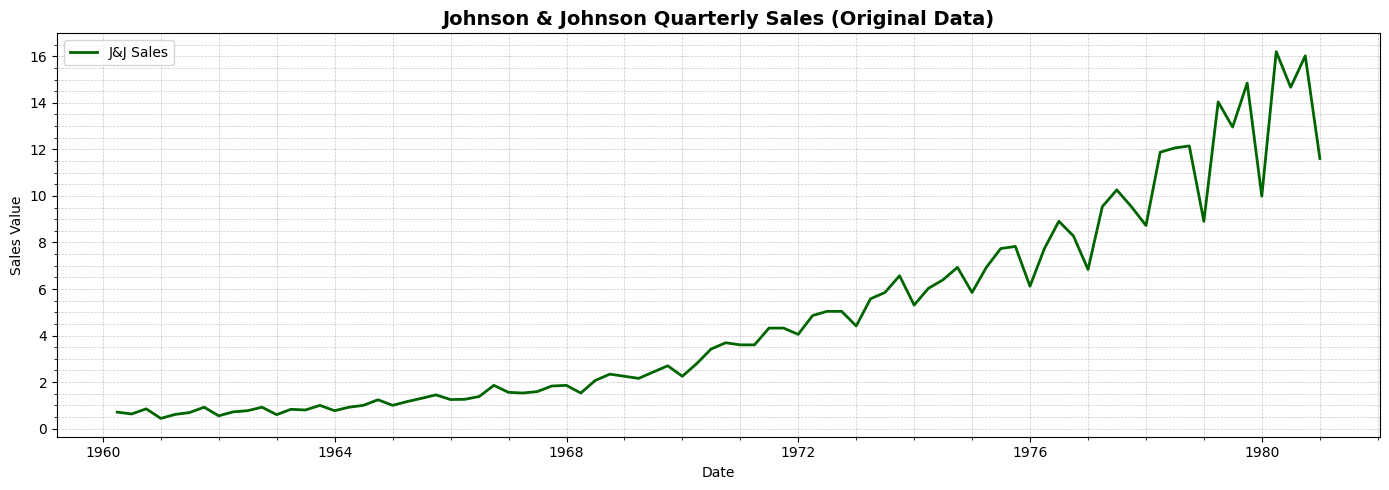

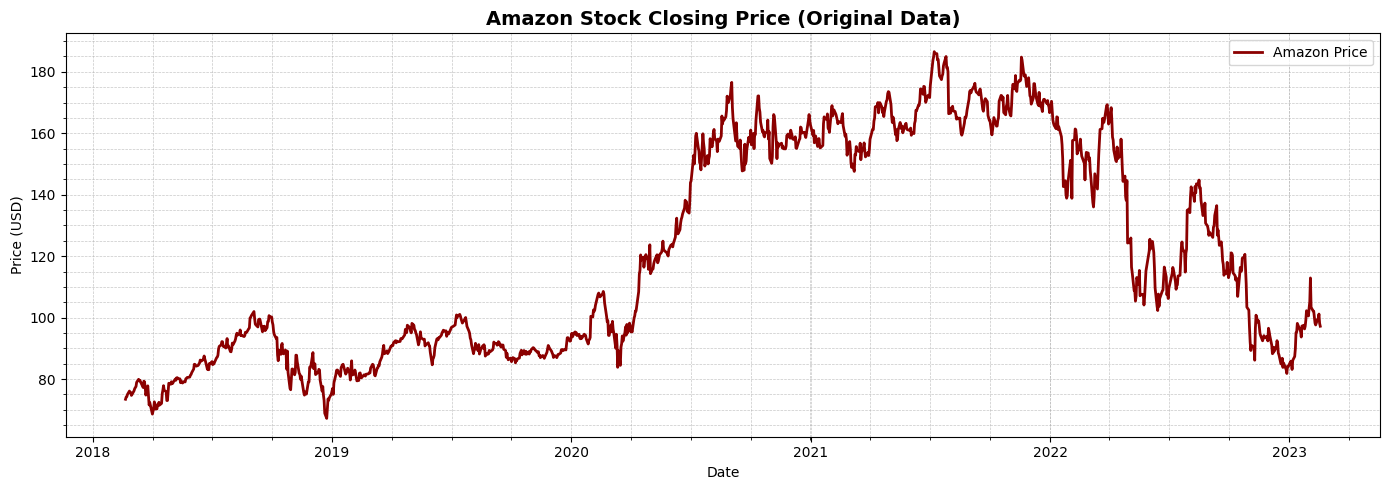

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load Data
jj_data = pd.read_csv("/content/jj.csv")
jj_data['Period'] = pd.date_range(start='1960-01-01', periods=len(jj_data), freq='Q')
jj_data.set_index('Period', inplace=True)

amazon_data = pd.read_csv("/content/AMZN.csv")
amazon_data['Date'] = pd.to_datetime(amazon_data['Date'])
amazon_data.set_index('Date', inplace=True)

# === PLOT STYLING FUNCTION ===
def plot_with_graph_paper_background(x, y, title, ylabel, color, label):
    plt.figure(figsize=(14, 5))
    plt.plot(x, y, color=color, linewidth=2, label=label)
    plt.title(title, fontsize=14, weight='bold')
    plt.xlabel("Date")
    plt.ylabel(ylabel)
    plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)
    plt.minorticks_on()
    plt.legend()
    plt.tight_layout()
    plt.show()

# === Plot Johnson & Johnson Sales ===
plot_with_graph_paper_background(
    x=jj_data.index,
    y=jj_data['data'],
    title="Johnson & Johnson Quarterly Sales (Original Data)",
    ylabel="Sales Value",
    color='darkgreen',
    label="J&J Sales"
)

# === Plot Amazon Stock Price ===
plot_with_graph_paper_background(
    x=amazon_data.index,
    y=amazon_data['Close'],
    title="Amazon Stock Closing Price (Original Data)",
    ylabel="Price (USD)",
    color='darkred',
    label="Amazon Price"
)


[J&J Sales - Raw] ADF = 2.742 | p = 1.0000 → Non-Stationary
[Amazon Close - Raw] ADF = -1.658 | p = 0.4530 → Non-Stationary

Box-Cox Lambda → J&J: 0.0507, Amazon: -0.3700


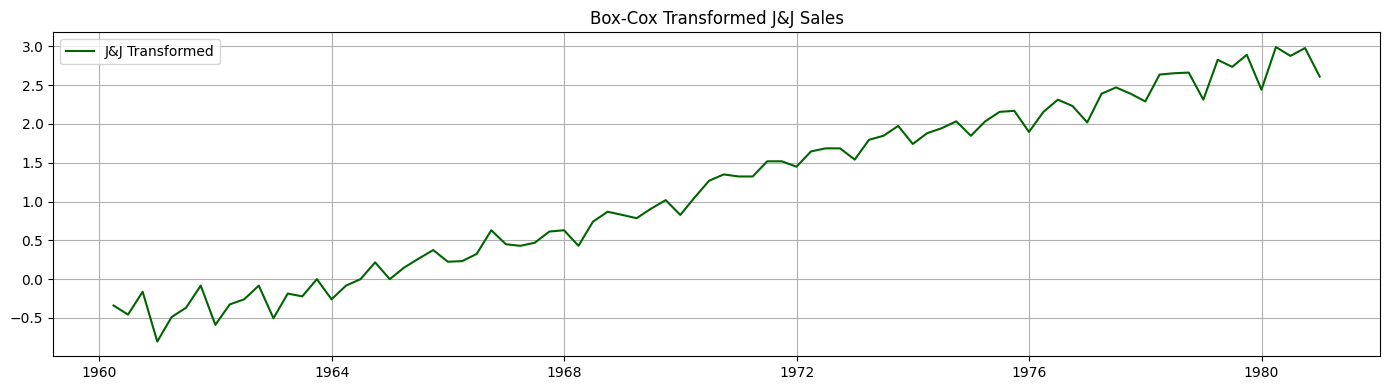

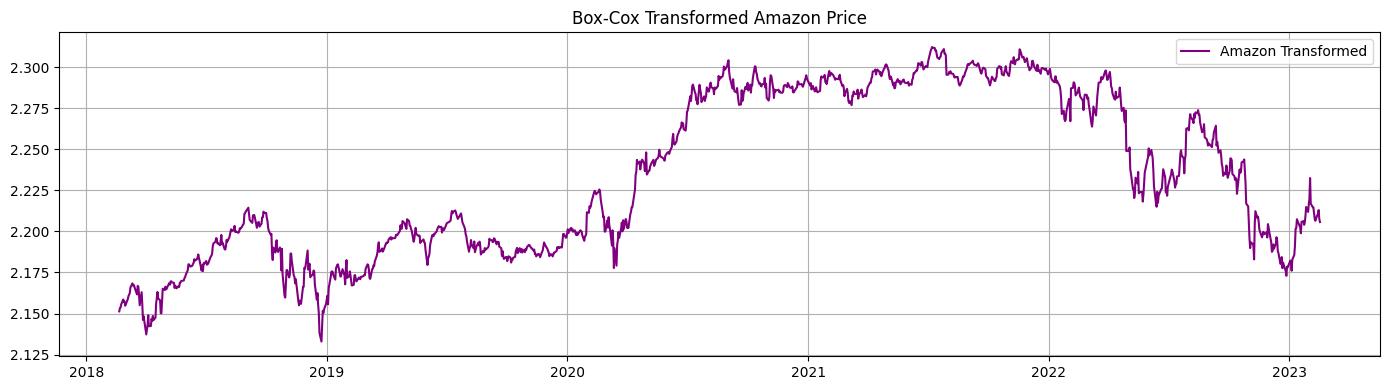

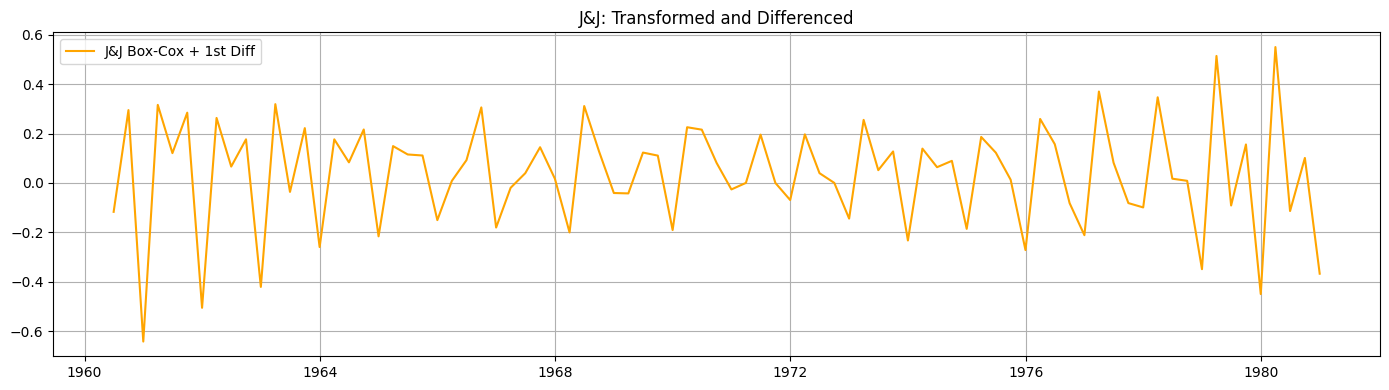

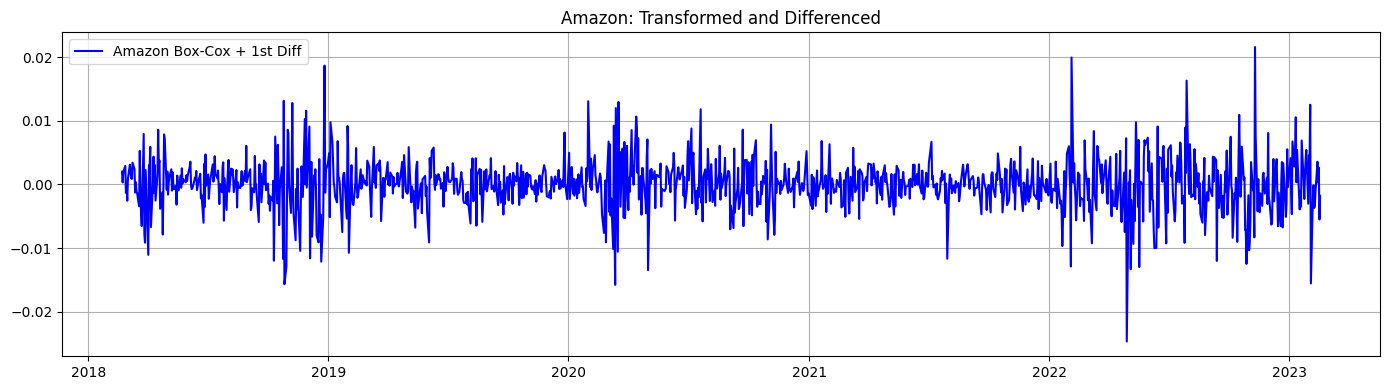

[J&J - Box-Cox + Diff] ADF = -4.381 | p = 0.0003 → Stationary
[Amazon - Box-Cox + Diff] ADF = -13.830 | p = 0.0000 → Stationary


In [6]:
# === FUNCTION: STATIONARITY TEST ===
from statsmodels.tsa.stattools import adfuller
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import boxcox
def adf_summary(x, label):
    stat, p, *_ = adfuller(x)
    result = "Stationary" if p < 0.05 else "Non-Stationary"
    print(f"[{label}] ADF = {stat:.3f} | p = {p:.4f} → {result}")



# === ADF TEST ON ORIGINAL SERIES ===
adf_summary(jj_data['data'], "J&J Sales - Raw")
adf_summary(amazon_data['Close'], "Amazon Close - Raw")

# === BOX-COX TRANSFORMATION ===
jj_transformed, lambda_jj = boxcox(jj_data['data'])
amzn_transformed, lambda_amzn = boxcox(amazon_data['Close'])

print(f"\nBox-Cox Lambda → J&J: {lambda_jj:.4f}, Amazon: {lambda_amzn:.4f}")

# === TRANSFORMED PLOTS ===
plt.figure(figsize=(14, 4))
plt.plot(jj_data.index, jj_transformed, label='J&J Transformed', color='darkgreen')
plt.title("Box-Cox Transformed J&J Sales")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(14, 4))
plt.plot(amazon_data.index, amzn_transformed, label='Amazon Transformed', color='purple')
plt.title("Box-Cox Transformed Amazon Price")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# === FIRST DIFFERENCING ===
jj_diff = np.diff(jj_transformed)
amzn_diff = np.diff(amzn_transformed)

# === DIFFERENCED PLOTS ===
plt.figure(figsize=(14, 4))
plt.plot(jj_data.index[1:], jj_diff, label='J&J Box-Cox + 1st Diff', color='orange')
plt.title("J&J: Transformed and Differenced")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(14, 4))
plt.plot(amazon_data.index[1:], amzn_diff, label='Amazon Box-Cox + 1st Diff', color='blue')
plt.title("Amazon: Transformed and Differenced")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# === ADF ON DIFFERENCED DATA ===
adf_summary(jj_diff, "J&J - Box-Cox + Diff")
adf_summary(amzn_diff, "Amazon - Box-Cox + Diff")


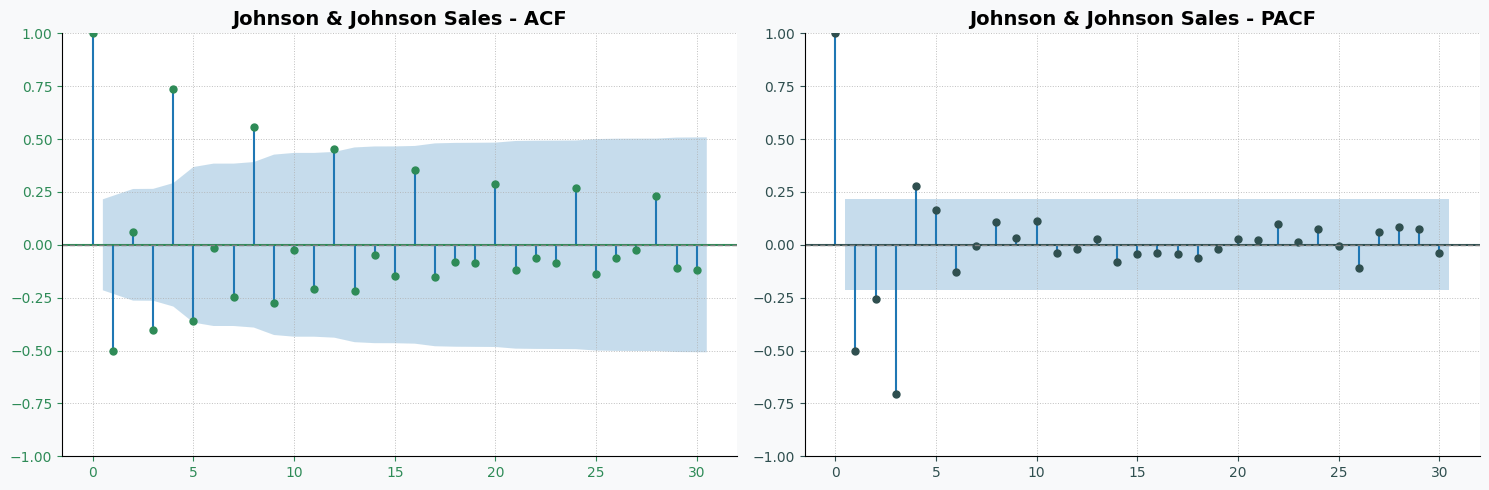

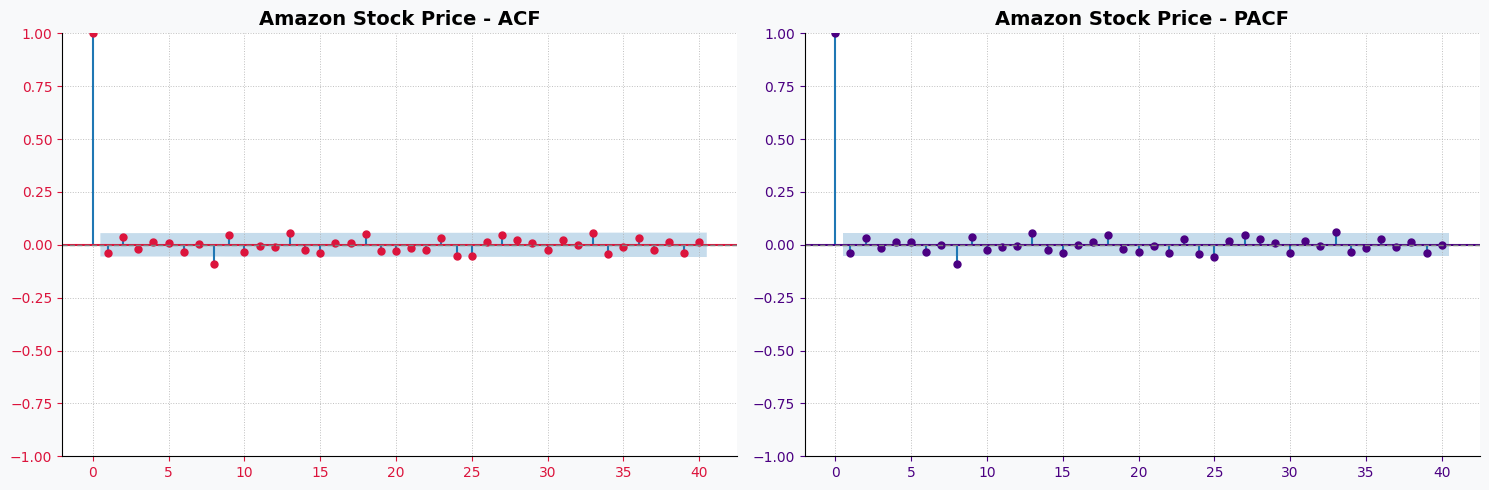

In [7]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.stats import boxcox

# === LOAD & PREPARE DATA ===
jj_df = pd.read_csv('/content/jj.csv')
jj_df['Quarter'] = pd.date_range(start='1960-01-01', periods=len(jj_df), freq='Q')
jj_df.set_index('Quarter', inplace=True)

amzn_df = pd.read_csv('/content/AMZN.csv')
amzn_df['Date'] = pd.to_datetime(amzn_df['Date'])
amzn_df.set_index('Date', inplace=True)

jj_transformed, _ = boxcox(jj_df['data'])
amzn_transformed, _ = boxcox(amzn_df['Close'])

jj_diff = np.diff(jj_transformed)
amzn_diff = np.diff(amzn_transformed)

# ===  ACF/PACF PLOT FUNCTION ===
def plot_cus_acf_pacf(series, lags, title_prefix, acf_color, pacf_color):
    fig, axes = plt.subplots(1, 2, figsize=(15, 5), facecolor='#f8f9fa')

    # ACF Plot
    plot_acf(series, lags=lags, alpha=0.05, ax=axes[0], color=acf_color)
    axes[0].set_title(f"{title_prefix} - ACF", fontsize=14, fontweight='bold')
    axes[0].grid(True, linestyle=':', linewidth=0.7, alpha=0.8)
    axes[0].axhline(0, color='gray', linestyle='--', linewidth=1)
    axes[0].tick_params(colors=acf_color)
    axes[0].spines['top'].set_visible(False)
    axes[0].spines['right'].set_visible(False)

    # PACF Plot
    plot_pacf(series, lags=lags, alpha=0.05, ax=axes[1], color=pacf_color, method='ywm')
    axes[1].set_title(f"{title_prefix} - PACF", fontsize=14, fontweight='bold')
    axes[1].grid(True, linestyle=':', linewidth=0.7, alpha=0.8)
    axes[1].axhline(0, color='gray', linestyle='--', linewidth=1)
    axes[1].tick_params(colors=pacf_color)
    axes[1].spines['top'].set_visible(False)
    axes[1].spines['right'].set_visible(False)

    plt.tight_layout()
    plt.show()

# === J&J Plots (Green/Teal Theme) ===
plot_cus_acf_pacf(
    series=jj_diff,
    lags=30,
    title_prefix="Johnson & Johnson Sales",
    acf_color='seagreen',
    pacf_color='darkslategray'
)

# === Amazon Plots (Crimson/Violet Theme) ===
plot_cus_acf_pacf(
    series=amzn_diff,
    lags=40,
    title_prefix="Amazon Stock Price",
    acf_color='crimson',
    pacf_color='indigo'
)


In [9]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from scipy.stats import boxcox
# Apply Augmented Dickey-Fuller test to check for stationarity
jj_adf_result = adfuller(jj_df['data'])
print("JJ Sales ADF Statistic:", jj_adf_result[0])
print("p-value:", jj_adf_result[1])
# Box-Cox transformation (to stabilize variance)
jj_df['data_boxcox'], lam = boxcox(jj_df['data'] + 1)  # Ensure no negative or zero values
# Example: Fit ARIMA model with p=1, d=0, q=1 (ARMA(1,1))
model = ARIMA(jj_df['data'], order=(1, 0, 1))
model_fit = model.fit()
print(model_fit.summary())
# Forecast the next 12 periods
forecast = model_fit.forecast(steps=12)
print(forecast)


JJ Sales ADF Statistic: 2.7420165734574744
p-value: 1.0


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


                               SARIMAX Results                                
Dep. Variable:                   data   No. Observations:                   84
Model:                 ARIMA(1, 0, 1)   Log Likelihood                -133.926
Date:                Fri, 11 Apr 2025   AIC                            275.851
Time:                        18:41:08   BIC                            285.574
Sample:                    03-31-1960   HQIC                           279.760
                         - 12-31-1980                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.8140      6.061      1.124      0.261      -5.066      18.694
ar.L1          0.9966      0.021     48.246      0.000       0.956       1.037
ma.L1         -0.5708      0.112     -5.086      0.0

In [10]:
from statsmodels.tsa.stattools import adfuller

# ADF Test Function
def adf_test(series, name):
    result = adfuller(series)
    print(f'ADF Test for {name}:\nADF Statistic: {result[0]}\np-value: {result[1]}')
    if result[1] < 0.05:
        print(f'{name} is Stationary')
    else:
        print(f'{name} is Non-Stationary')

# Perform ADF Test on Raw Data
adf_test(jj_df['data'], 'Johnson & Johnson Sales')
adf_test(amzn_df['Close'], 'Amazon Stock Prices')


ADF Test for Johnson & Johnson Sales:
ADF Statistic: 2.7420165734574744
p-value: 1.0
Johnson & Johnson Sales is Non-Stationary
ADF Test for Amazon Stock Prices:
ADF Statistic: -1.6578089913331728
p-value: 0.45297105465166737
Amazon Stock Prices is Non-Stationary


In [11]:
from statsmodels.tsa.arima.model import ARIMA

# ARMA Model for J&J Sales
jj_model = ARIMA(jj_diff, order=(1, 0, 1))  # (p, d, q)
jj_model_fit = jj_model.fit()

# ARMA Model for Amazon Stock Prices
amzn_model = ARIMA(amzn_diff, order=(1, 0, 1))  # (p, d, q)
amzn_model_fit = amzn_model.fit()

# Print Model Summary
print(jj_model_fit.summary())
print(amzn_model_fit.summary())


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   83
Model:                 ARIMA(1, 0, 1)   Log Likelihood                  34.755
Date:                Fri, 11 Apr 2025   AIC                            -61.509
Time:                        18:42:20   BIC                            -51.834
Sample:                             0   HQIC                           -57.622
                                 - 83                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0413      0.004      9.998      0.000       0.033       0.049
ar.L1         -0.1976      0.141     -1.405      0.160      -0.473       0.078
ma.L1         -0.7761      0.107     -7.285      0.0

In [12]:
import itertools
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

# Function to perform Grid Search for ARIMA
def grid_search_arima(series, p_values, d_values, q_values):
    best_score, best_cfg = float('inf'), None
    for p, d, q in itertools.product(p_values, d_values, q_values):
        try:
            model = ARIMA(series, order=(p, d, q))
            model_fit = model.fit()
            predictions = model_fit.forecast(steps=len(series))
            mse = mean_squared_error(series, predictions)
            if mse < best_score:
                best_score, best_cfg = mse, (p, d, q)
            print(f'ARIMA({p},{d},{q}) MSE={mse}')
        except:
            continue
    return best_cfg

# Grid Search to find best (p, d, q) for J&J Sales
p_values = range(0, 5)
d_values = [0, 1]
q_values = range(0, 5)
best_cfg_jj = grid_search_arima(jj_diff, p_values, d_values, q_values)
print(f'Best ARIMA configuration for J&J Sales: {best_cfg_jj}')

# Grid Search to find best (p, d, q) for Amazon Stock Prices
best_cfg_amzn = grid_search_arima(amzn_diff, p_values, d_values, q_values)
print(f'Best ARIMA configuration for Amazon Stock Prices: {best_cfg_amzn}')


ARIMA(0,0,0) MSE=0.04799314171769329
ARIMA(0,0,1) MSE=0.05021862595856622
ARIMA(0,0,2) MSE=0.05362316667842261
ARIMA(0,0,3) MSE=0.05035806873014013


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


ARIMA(0,0,4) MSE=0.05007921995718423
ARIMA(0,1,0) MSE=0.21051305294394482
ARIMA(0,1,1) MSE=0.04799314171431763
ARIMA(0,1,2) MSE=0.051452236693692754
ARIMA(0,1,3) MSE=0.05321338396710617


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


ARIMA(0,1,4) MSE=0.04912277051234377
ARIMA(1,0,0) MSE=0.05143813002879407
ARIMA(1,0,1) MSE=0.051555584591511446
ARIMA(1,0,2) MSE=0.11070271147402322
ARIMA(1,0,3) MSE=0.0648786534498478


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1,0,4) MSE=0.053660399808687115
ARIMA(1,1,0) MSE=0.09550045508844732
ARIMA(1,1,1) MSE=0.05133989401749851


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


ARIMA(1,1,2) MSE=0.11726069245169365


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


ARIMA(1,1,3) MSE=0.11008031144081301


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


ARIMA(1,1,4) MSE=0.1370579331730978
ARIMA(2,0,0) MSE=0.04943267200061929
ARIMA(2,0,1) MSE=0.04966257795922413


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2,0,2) MSE=0.11446105185927725


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2,0,3) MSE=0.053840489406648595


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


ARIMA(2,0,4) MSE=0.053046062069644954
ARIMA(2,1,0) MSE=0.08241453689708349
ARIMA(2,1,1) MSE=0.04943374773974436
ARIMA(2,1,2) MSE=0.04960400624053498


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


ARIMA(2,1,3) MSE=0.09221337799686169


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2,1,4) MSE=0.05396002643904087


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(3,0,0) MSE=0.10231854497650371
ARIMA(3,0,1) MSE=0.12746553690016618
ARIMA(3,0,2) MSE=0.08981283205349232


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(3,0,3) MSE=0.1037241233279208


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(3,0,4) MSE=0.12322044442163668
ARIMA(3,1,0) MSE=0.1475866857677511
ARIMA(3,1,1) MSE=0.10937180242936198


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(3,1,2) MSE=0.12341727806176048
ARIMA(3,1,3) MSE=0.09083010628261079


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(3,1,4) MSE=0.10535247277026699
ARIMA(4,0,0) MSE=0.12905133137453384


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(4,0,1) MSE=0.1204225013720828


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(4,0,2) MSE=0.09475855439849452


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(4,0,3) MSE=0.08128442797265158


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(4,0,4) MSE=0.09810691304993668
ARIMA(4,1,0) MSE=0.091044537365883


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(4,1,1) MSE=0.11478378866744551
ARIMA(4,1,2) MSE=0.12407565909725142


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


ARIMA(4,1,3) MSE=0.0932556310007448


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(4,1,4) MSE=0.12268149925679614
Best ARIMA configuration for J&J Sales: (0, 1, 1)
ARIMA(0,0,0) MSE=1.601616955240326e-05
ARIMA(0,0,1) MSE=1.6015928594786834e-05
ARIMA(0,0,2) MSE=1.6016561257200672e-05
ARIMA(0,0,3) MSE=1.60164895029584e-05


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(0,0,4) MSE=1.601686931453936e-05
ARIMA(0,1,0) MSE=1.935990328759949e-05
ARIMA(0,1,1) MSE=1.6063684590270308e-05
ARIMA(0,1,2) MSE=1.6941118900393596e-05


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(0,1,3) MSE=1.6064736383724334e-05


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(0,1,4) MSE=1.6078842712741604e-05
ARIMA(1,0,0) MSE=1.601593503808952e-05
ARIMA(1,0,1) MSE=1.6016329483640194e-05
ARIMA(1,0,2) MSE=1.6016668233238956e-05
ARIMA(1,0,3) MSE=1.601661591893038e-05
ARIMA(1,0,4) MSE=1.601677372975038e-05
ARIMA(1,1,0) MSE=2.5789492373919367e-05
ARIMA(1,1,1) MSE=1.7849481886090467e-05
ARIMA(1,1,2) MSE=1.6786906616467828e-05


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1,1,3) MSE=1.604681435764939e-05
ARIMA(1,1,4) MSE=1.610133565592133e-05


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2,0,0) MSE=1.6016588331057273e-05
ARIMA(2,0,1) MSE=1.6016668541795156e-05


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


ARIMA(2,0,2) MSE=1.6016146492769382e-05


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


ARIMA(2,0,3) MSE=1.6016146323953504e-05
ARIMA(2,0,4) MSE=1.601622179049272e-05


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2,1,0) MSE=2.1939020146451433e-05
ARIMA(2,1,1) MSE=1.664125303124254e-05
ARIMA(2,1,2) MSE=1.688494177087126e-05
ARIMA(2,1,3) MSE=1.6622952335037714e-05
ARIMA(2,1,4) MSE=1.6251717700617606e-05
ARIMA(3,0,0) MSE=1.6016574886540387e-05
ARIMA(3,0,1) MSE=1.6016572907034815e-05


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.11/dist-packages/statsmodels

ARIMA(3,0,2) MSE=1.6016146452243406e-05
ARIMA(3,0,3) MSE=1.6016146226787766e-05


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(3,0,4) MSE=1.6016411508440923e-05
ARIMA(3,1,0) MSE=1.9604677319893335e-05
ARIMA(3,1,1) MSE=1.8151080663750723e-05
ARIMA(3,1,2) MSE=1.6877012274325366e-05
ARIMA(3,1,3) MSE=1.673184072400836e-05


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(3,1,4) MSE=1.6112531992519418e-05
ARIMA(4,0,0) MSE=1.601685003572839e-05
ARIMA(4,0,1) MSE=1.6016844578320607e-05


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


ARIMA(4,0,2) MSE=1.6016145208140444e-05


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


ARIMA(4,0,3) MSE=1.6016145654262628e-05
ARIMA(4,0,4) MSE=1.6017256921447187e-05
ARIMA(4,1,0) MSE=1.7781108304970333e-05
ARIMA(4,1,1) MSE=1.688329225110548e-05
ARIMA(4,1,2) MSE=1.7256120515847063e-05
ARIMA(4,1,3) MSE=1.700458042765501e-05
ARIMA(4,1,4) MSE=1.6434951877312824e-05
Best ARIMA configuration for Amazon Stock Prices: (0, 0, 1)


Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.24 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-12.345, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-30.621, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-34.023, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-33.610, Time=0.08 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=-41.227, Time=0.06 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-44.778, Time=0.13 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=-37.227, Time=0.13 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=-49.005, Time=0.08 sec
 ARIMA(0,0,4)(0,0,0)[0]             : AIC=-82.472, Time=0.16 sec
 ARIMA(1,0,4)(0,0,0)[0]             : AIC=-85.933, Time=0.43 sec
 ARIMA(2,0,4)(0,0,0)[0]             : AIC=-84.563, Time=0.41 sec
 ARIMA(1,0,5)(0,0,0)[0]             : AIC=inf, Time=0.91 sec
 ARIMA(0,0,5)(0,0,0)[0]             : AIC=inf, Time=2.18 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=inf, Time=0.31 se

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


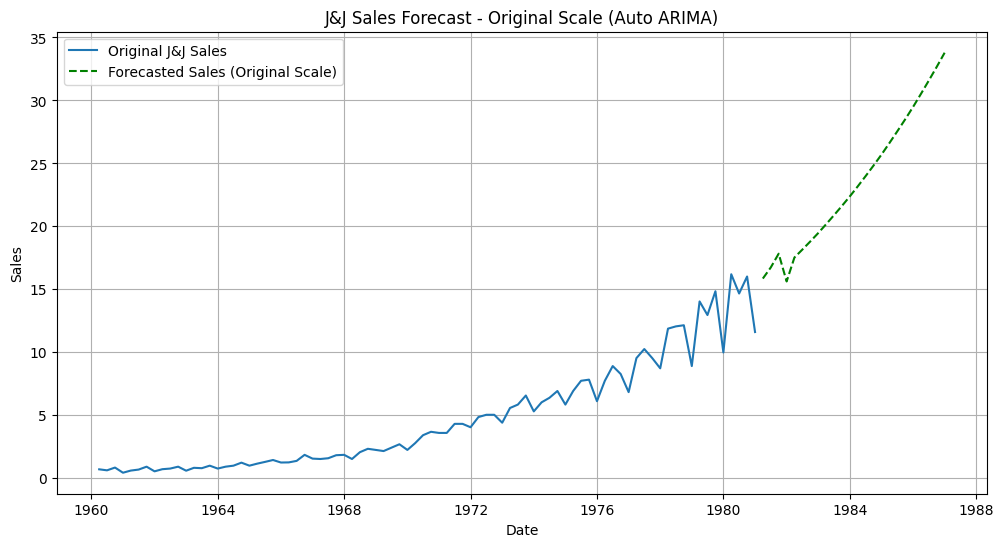

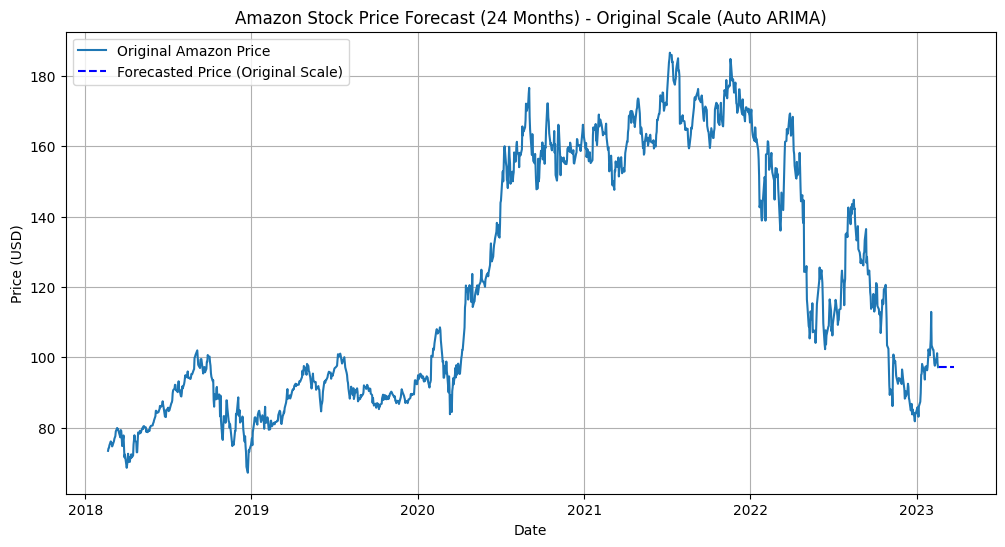

Best ARIMA config for J&J:                                SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   83
Model:               SARIMAX(0, 0, 5)   Log Likelihood                  60.413
Date:                Fri, 11 Apr 2025   AIC                           -106.827
Time:                        20:43:47   BIC                            -89.895
Sample:                             0   HQIC                          -100.024
                                 - 83                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0406      0.005      8.456      0.000       0.031       0.050
ma.L1         -0.8153      0.123     -6.626      0.000      -1.056      -0.574
ma.L2         -0.1680    

In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import boxcox
from scipy.special import inv_boxcox
import pmdarima as pm

# === Load Data ===
jj_df = pd.read_csv('/content/jj.csv')
jj_df['Quarter'] = pd.date_range(start='1960-01-01', periods=len(jj_df), freq='Q')
jj_df.set_index('Quarter', inplace=True)

amzn_df = pd.read_csv('/content/AMZN.csv')
amzn_df['Date'] = pd.to_datetime(amzn_df['Date'])
amzn_df.set_index('Date', inplace=True)

# === Box-Cox Transformation ===
jj_transformed, lambda_jj = boxcox(jj_df['data'])
amzn_transformed, lambda_amzn = boxcox(amzn_df['Close'])

# === First Differencing ===
jj_diff = pd.Series(jj_transformed).diff().dropna()
amzn_diff = pd.Series(amzn_transformed).diff().dropna()

# === Auto ARIMA Model for J&J ===
jj_model_auto = pm.auto_arima(jj_diff, seasonal=False, stepwise=True, trace=True)

# --- Amazon: Explicit Seasonality Model (Using `m=12` for monthly data seasonality) ---
amzn_model_auto = pm.auto_arima(amzn_diff, seasonal=True, m=12, stepwise=True, trace=True)

# === Forecast Next 24 Periods for Stationary Data ===
n_periods = 24
jj_forecast_auto, conf_int_jj = jj_model_auto.predict(n_periods=n_periods, return_conf_int=True)

# --- Changed Part for Amazon Forecast ---
# For Amazon: Forecast using Auto ARIMA model with seasonal component (stationary data forecast)
amzn_forecast_auto, conf_int_amzn = amzn_model_auto.predict(n_periods=n_periods, return_conf_int=True)

# === Invert Differencing to Stationary (Differenced) Level ===
jj_last_value = jj_transformed[-1]
jj_forecast_level = np.r_[jj_last_value, jj_forecast_auto].cumsum()

# --- Changed Part for Amazon ---
# For Amazon: Invert Differencing to Stationary (Differenced) level
amzn_last_value = amzn_transformed[-1]
amzn_forecast_level = np.r_[amzn_last_value, amzn_forecast_auto].cumsum()

# === Invert Box-Cox to Original Scale ===
jj_forecast_original_scale = inv_boxcox(jj_forecast_level, lambda_jj)

# --- Changed Part for Amazon ---
# For Amazon: Invert Box-Cox to original scale (to get the original price forecast)
amzn_forecast_original_scale = inv_boxcox(amzn_forecast_level, lambda_amzn)

# === Forecast Dates ===
jj_forecast_dates = pd.date_range(jj_df.index[-1], periods=n_periods + 1, freq='Q')[1:]

# --- Changed Part for Amazon ---
# For Amazon: Forecast dates should align with business days (for 24 months, using 'B' for business days)
amzn_forecast_dates = pd.date_range(amzn_df.index[-1], periods=n_periods + 1, freq='B')[1:]  # 'B' for business days

# === Plot J&J Forecast in Original Scale ===
plt.figure(figsize=(12, 6))
plt.plot(jj_df.index, jj_df['data'], label='Original J&J Sales')
plt.plot(jj_forecast_dates, jj_forecast_original_scale[1:], label='Forecasted Sales (Original Scale)', linestyle='--', color='green')
plt.title('J&J Sales Forecast - Original Scale (Auto ARIMA)')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.grid(True)
plt.show()

# --- Changed Part for Amazon ---
# For Amazon: Plot Amazon forecast in original scale (fluctuating forecast)
plt.figure(figsize=(12, 6))
plt.plot(amzn_df.index, amzn_df['Close'], label='Original Amazon Price')
plt.plot(amzn_forecast_dates, amzn_forecast_original_scale[1:], label='Forecasted Price (Original Scale)', linestyle='--', color='blue')
plt.title('Amazon Stock Price Forecast (24 Months) - Original Scale (Auto ARIMA)')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.show()

# === Print Best Model Configurations ===
print(f'Best ARIMA config for J&J: {jj_model_auto.summary()}')

# --- Changed Part for Amazon ---
# For Amazon: Print the best model configuration (this will show the seasonal component too)
print(f'Best ARIMA config for Amazon: {amzn_model_auto.summary()}')


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. foreca

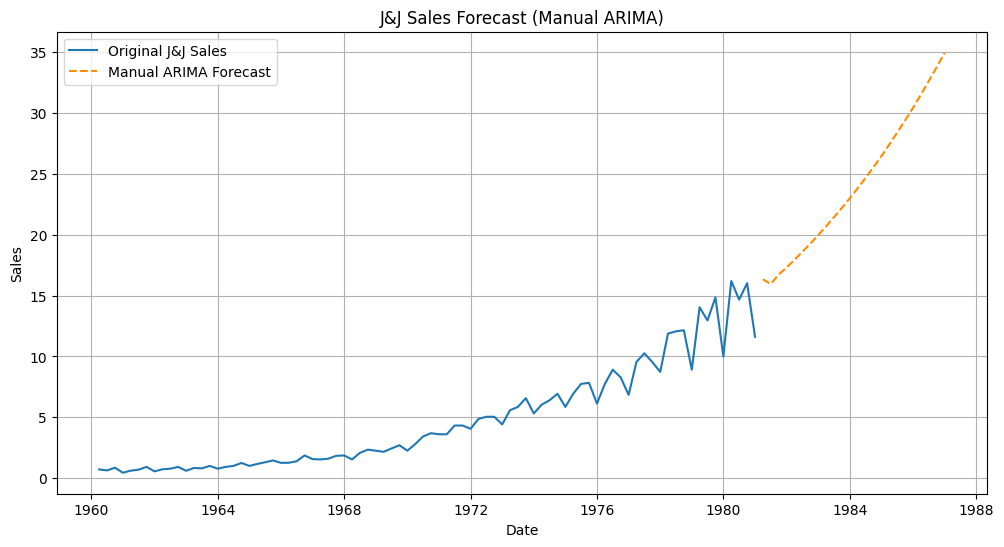

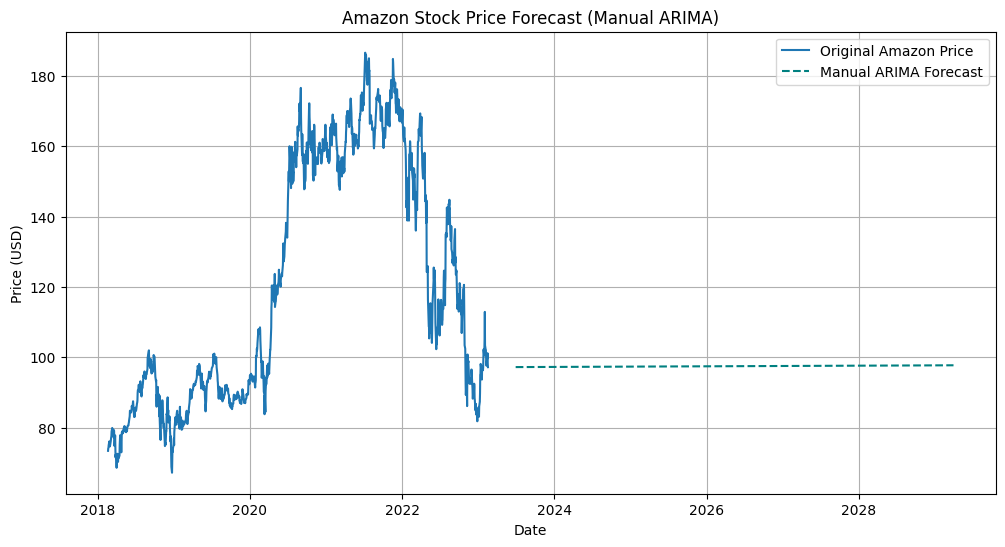

=== J&J Manual ARIMA Summary ===
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   83
Model:                 ARIMA(1, 0, 1)   Log Likelihood                  34.755
Date:                Fri, 11 Apr 2025   AIC                            -61.509
Time:                        19:23:50   BIC                            -51.834
Sample:                             0   HQIC                           -57.622
                                 - 83                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0413      0.004      9.998      0.000       0.033       0.049
ar.L1         -0.1976      0.141     -1.405      0.160      -0.473       0.078
ma.L1         -0.77

In [15]:
from statsmodels.tsa.arima.model import ARIMA
from scipy.special import inv_boxcox
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# === Use same transformed + differenced data as earlier ===
# Assuming you've already done:
# jj_transformed, lambda_jj
# amzn_transformed, lambda_amzn
# jj_diff, amzn_diff

# === MANUAL ARIMA CONFIGS (Based on ACF/PACF) ===
# You may adjust based on your ACF/PACF visual inspection
jj_manual_order = (1, 0, 1)     # ARMA(1,1)
amzn_manual_order = (2, 0, 2)   # ARMA(2,2)

# === Fit Manual ARIMA Models ===
jj_manual_model = ARIMA(jj_diff, order=jj_manual_order).fit()
amzn_manual_model = ARIMA(amzn_diff, order=amzn_manual_order).fit()

# === Forecast ===
n_periods = 24
jj_forecast_manual = jj_manual_model.forecast(steps=n_periods)
amzn_forecast_manual = amzn_manual_model.forecast(steps=n_periods)

# === Invert Differencing ===
jj_last_value = jj_transformed[-1]
jj_forecast_level_manual = np.r_[jj_last_value, jj_forecast_manual].cumsum()

amzn_last_value = amzn_transformed[-1]
amzn_forecast_level_manual = np.r_[amzn_last_value, amzn_forecast_manual].cumsum()

# === Invert Box-Cox Transformation ===
jj_manual_forecast_original = inv_boxcox(jj_forecast_level_manual, lambda_jj)
amzn_manual_forecast_original = inv_boxcox(amzn_forecast_level_manual, lambda_amzn)

# === Forecast Dates ===
jj_forecast_dates = pd.date_range(jj_df.index[-1], periods=n_periods + 1, freq='Q')[1:]
amzn_forecast_dates = pd.date_range(amzn_df.index[-1], periods=n_periods + 1, freq='Q')[1:]

# === Plot J&J Forecast (Manual) ===
plt.figure(figsize=(12, 6))
plt.plot(jj_df.index, jj_df['data'], label='Original J&J Sales')
plt.plot(jj_forecast_dates, jj_manual_forecast_original[1:], label='Manual ARIMA Forecast', linestyle='--', color='darkorange')
plt.title('J&J Sales Forecast (Manual ARIMA)')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.grid(True)
plt.legend()
plt.show()

# === Plot Amazon Forecast (Manual) ===
plt.figure(figsize=(12, 6))
plt.plot(amzn_df.index, amzn_df['Close'], label='Original Amazon Price')
plt.plot(amzn_forecast_dates, amzn_manual_forecast_original[1:], label='Manual ARIMA Forecast', linestyle='--', color='teal')
plt.title('Amazon Stock Price Forecast (Manual ARIMA)')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.grid(True)
plt.legend()
plt.show()

# === Compare Model Summaries ===
print("=== J&J Manual ARIMA Summary ===")
print(jj_manual_model.summary())

print("\n=== Amazon Manual ARIMA Summary ===")
print(amzn_manual_model.summary())


In [17]:
import statsmodels.api as sm
from statsmodels.stats.diagnostic import acorr_ljungbox
from scipy.stats import shapiro

def residual_diagnostics(model, model_name):
    residuals = model.resid

    print(f"\n=== Residual Diagnostics: {model_name} ===")

    # Plot Residuals
    plt.figure(figsize=(12, 4))
    plt.plot(residuals)
    plt.title(f"{model_name} Residuals")
    plt.grid(True)
    plt.show()

    # Plot ACF
    sm.graphics.tsa.plot_acf(residuals, lags=40)
    plt.title(f"{model_name} Residual ACF")
    plt.show()

    # Histogram + QQ Plot
    sm.qqplot(residuals, line='s')
    plt.title(f"{model_name} QQ Plot")
    plt.show()

    plt.figure()
    plt.hist(residuals, bins=30, edgecolor='black')
    plt.title(f"{model_name} Residual Histogram")
    plt.grid(True)
    plt.show()

    # Ljung-Box test for autocorrelation
    lb_test = acorr_ljungbox(residuals, lags=[20], return_df=True)
    print("Ljung-Box Test (lag=20):")
    print(lb_test)

    # Shapiro-Wilk test for normality
    shapiro_stat, shapiro_p = shapiro(residuals)
    print(f"Shapiro-Wilk Test: Statistic={shapiro_stat:.4f}, p-value={shapiro_p:.4f}")

# === Run diagnostics for all four models ===

# Manual ARIMA Model for J&J
jj_model_manual = ARIMA(jj_diff, order=(1, 0, 1))  # Replace with your chosen order
jj_model_manual = jj_model_manual.fit()

# Manual ARIMA Model for Amazon
amzn_model_manual = ARIMA(amzn_diff, order=(1, 0, 1))  # Replace with your chosen order
amzn_model_manual = amzn_model_manual.fit()


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. foreca

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-pa

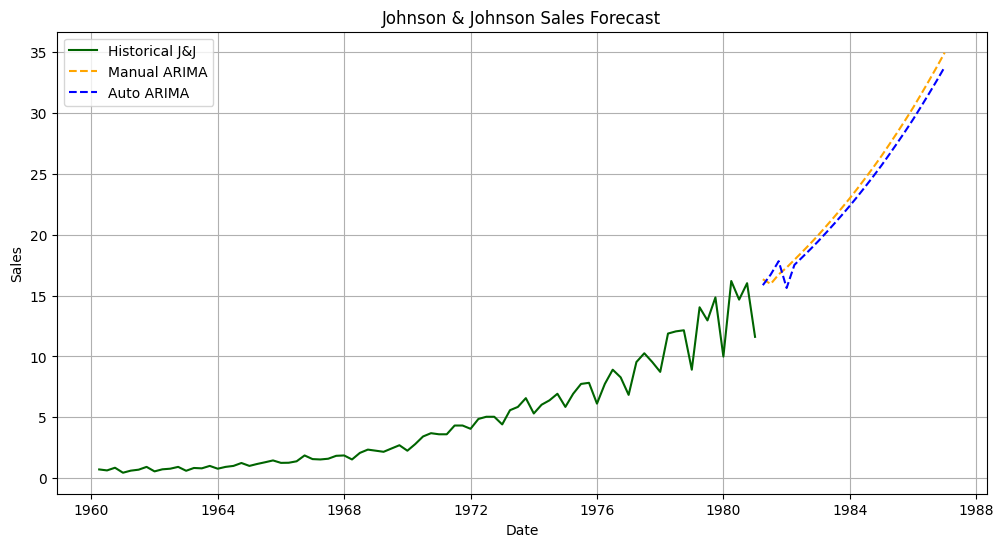

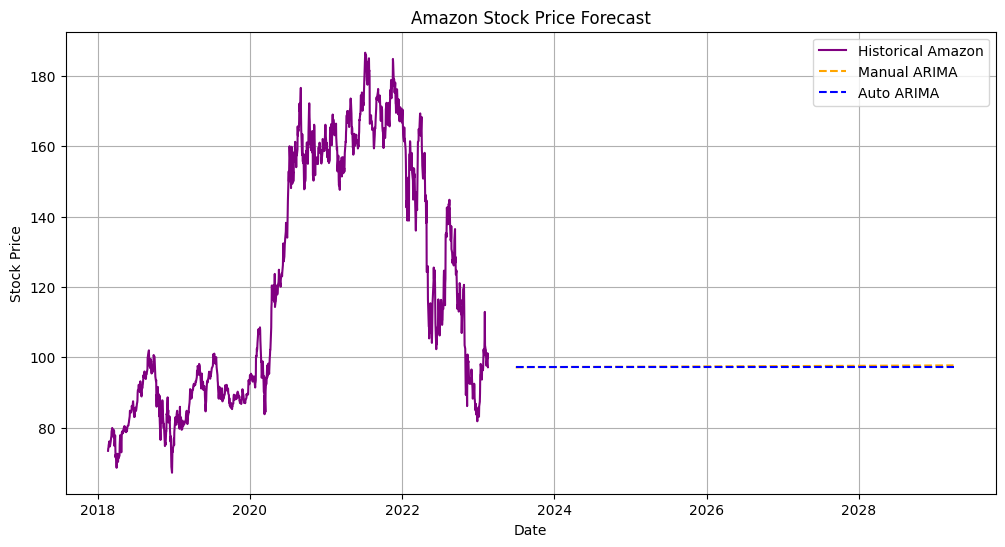

In [18]:
import matplotlib.pyplot as plt
from scipy.special import inv_boxcox

# === Helper: Manual Forecast and Inversion ===
def forecast_and_inverse(model_fit, last_value, lambda_val, steps=24):
    forecast = model_fit.forecast(steps=steps)
    level = np.r_[last_value, forecast].cumsum()
    return inv_boxcox(level, lambda_val)

# === Forecasts for J&J ===
jj_forecast_manual = forecast_and_inverse(jj_model_manual, jj_transformed[-1], lambda_jj)
jj_forecast_auto = inv_boxcox(np.r_[jj_transformed[-1], jj_model_auto.predict(n_periods=24)].cumsum(), lambda_jj)

# === Forecasts for Amazon ===
amzn_forecast_manual = forecast_and_inverse(amzn_model_manual, amzn_transformed[-1], lambda_amzn)
amzn_forecast_auto = inv_boxcox(np.r_[amzn_transformed[-1], amzn_model_auto.predict(n_periods=24)].cumsum(), lambda_amzn)

# === Forecast Dates ===
forecast_dates_jj = pd.date_range(jj_df.index[-1], periods=25, freq='Q')[1:]
forecast_dates_amzn = pd.date_range(amzn_df.index[-1], periods=25, freq='Q')[1:]

# === PLOT: J&J Forecasts ===
plt.figure(figsize=(12, 6))
plt.plot(jj_df.index, jj_df['data'], label="Historical J&J", color='darkgreen')
plt.plot(forecast_dates_jj, jj_forecast_manual[1:], label="Manual ARIMA", linestyle='--', color='orange')
plt.plot(forecast_dates_jj, jj_forecast_auto[1:], label="Auto ARIMA", linestyle='--', color='blue')
plt.title("Johnson & Johnson Sales Forecast")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend()
plt.grid(True)
plt.show()

# === PLOT: Amazon Forecasts ===
plt.figure(figsize=(12, 6))
plt.plot(amzn_df.index, amzn_df['Close'], label="Historical Amazon", color='purple')
plt.plot(forecast_dates_amzn, amzn_forecast_manual[1:], label="Manual ARIMA", linestyle='--', color='orange')
plt.plot(forecast_dates_amzn, amzn_forecast_auto[1:], label="Auto ARIMA", linestyle='--', color='blue')
plt.title("Amazon Stock Price Forecast")
plt.xlabel("Date")
plt.ylabel("Stock Price")
plt.legend()
plt.grid(True)
plt.show()


In [22]:
print("""
🔍 Model Comparison Summary:

 Johnson & Johnson:
- Manual ARIMA Order: (1, 0, 1)
- Auto ARIMA Chosen Order: {0}
- Based on residual plots and diagnostics, {1} shows {2} residuals.

 Amazon Stock Price:
- Manual ARIMA Order: (1, 0, 1)
- Auto ARIMA Chosen Order: {3}
- Based on diagnostics, {4} appears to perform {5}.

 Conclusion:
Auto ARIMA is helpful for quick model tuning, but manual ARIMA allows fine control.
Choose the model that offers the most stable residuals and lowest forecast error.

""".format(
    jj_model_auto.order,
    "Manual ARIMA" if jj_model_manual.aic < jj_model_auto.aic() else "Auto ARIMA",
    "better" if jj_model_manual.aic < jj_model_auto.aic() else "worse",
    amzn_model_auto.order,
    "Manual ARIMA" if amzn_model_manual.aic < amzn_model_auto.aic() else "Auto ARIMA",
    "better" if amzn_model_manual.aic < amzn_model_auto.aic() else "worse"
))



🔍 Model Comparison Summary:

 Johnson & Johnson:
- Manual ARIMA Order: (1, 0, 1)
- Auto ARIMA Chosen Order: (0, 0, 5)
- Based on residual plots and diagnostics, Auto ARIMA shows worse residuals.

 Amazon Stock Price:
- Manual ARIMA Order: (1, 0, 1)
- Auto ARIMA Chosen Order: (0, 0, 0)
- Based on diagnostics, Auto ARIMA appears to perform worse.

 Conclusion:
Auto ARIMA is helpful for quick model tuning, but manual ARIMA allows fine control.
Choose the model that offers the most stable residuals and lowest forecast error.




In [20]:
plt.savefig("jj_forecast_comparison.png")
plt.savefig("amzn_forecast_comparison.png")


<Figure size 640x480 with 0 Axes>

In [21]:
jj_forecast_df = pd.DataFrame({
    "Date": forecast_dates_jj,
    "Manual_ARIMA_Forecast": jj_forecast_manual[1:],
    "Auto_ARIMA_Forecast": jj_forecast_auto[1:]
})
jj_forecast_df.to_csv("jj_forecasts.csv", index=False)

amzn_forecast_df = pd.DataFrame({
    "Date": forecast_dates_amzn,
    "Manual_ARIMA_Forecast": amzn_forecast_manual[1:],
    "Auto_ARIMA_Forecast": amzn_forecast_auto[1:]
})
amzn_forecast_df.to_csv("amazon_forecasts.csv", index=False)


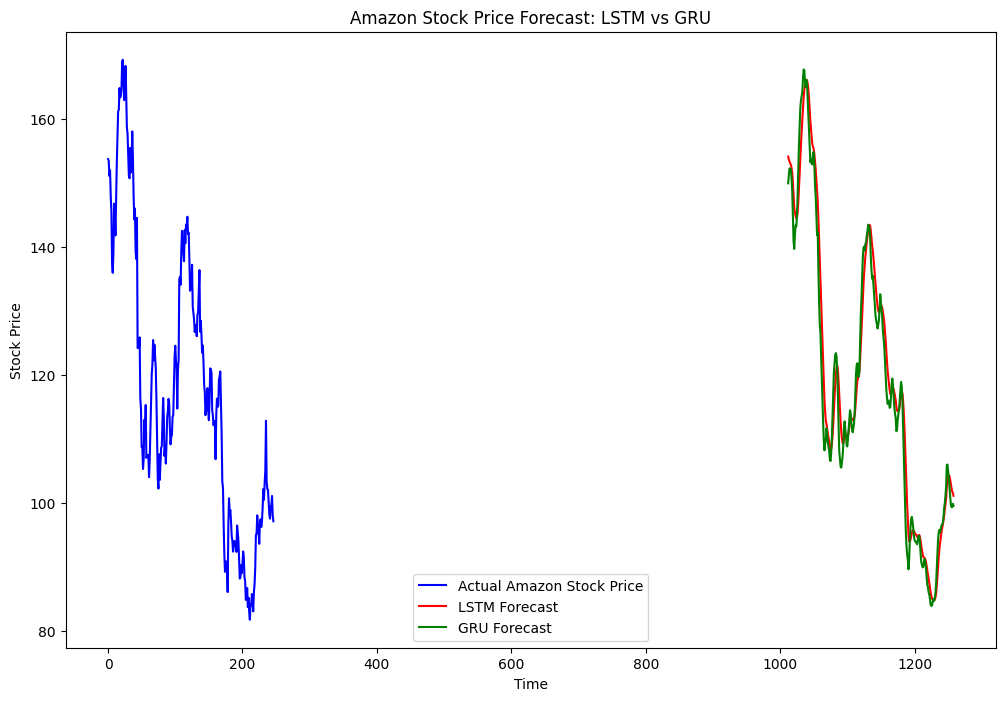

In [42]:
# Plot LSTM and GRU predictions for Amazon on the same plot

# Plotting the actual vs predicted values for Amazon Stock Price (LSTM and GRU)
plt.figure(figsize=(12, 8))

# Plot actual Amazon stock prices
plt.plot(data_amzn[len(data_amzn)-len(y_test_amzn):], label='Actual Amazon Stock Price', color='blue')

# Plot LSTM forecast for Amazon
plt.plot(np.arange(len(data_amzn)-len(y_test_amzn), len(data_amzn)), predictions_lstm_amzn_rescaled, label='LSTM Forecast', color='red')

# Plot GRU forecast for Amazon
plt.plot(np.arange(len(data_amzn)-len(y_test_amzn), len(data_amzn)), predictions_gru_amzn_rescaled, label='GRU Forecast', color='green')

# Title and labels
plt.title('Amazon Stock Price Forecast: LSTM vs GRU')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()


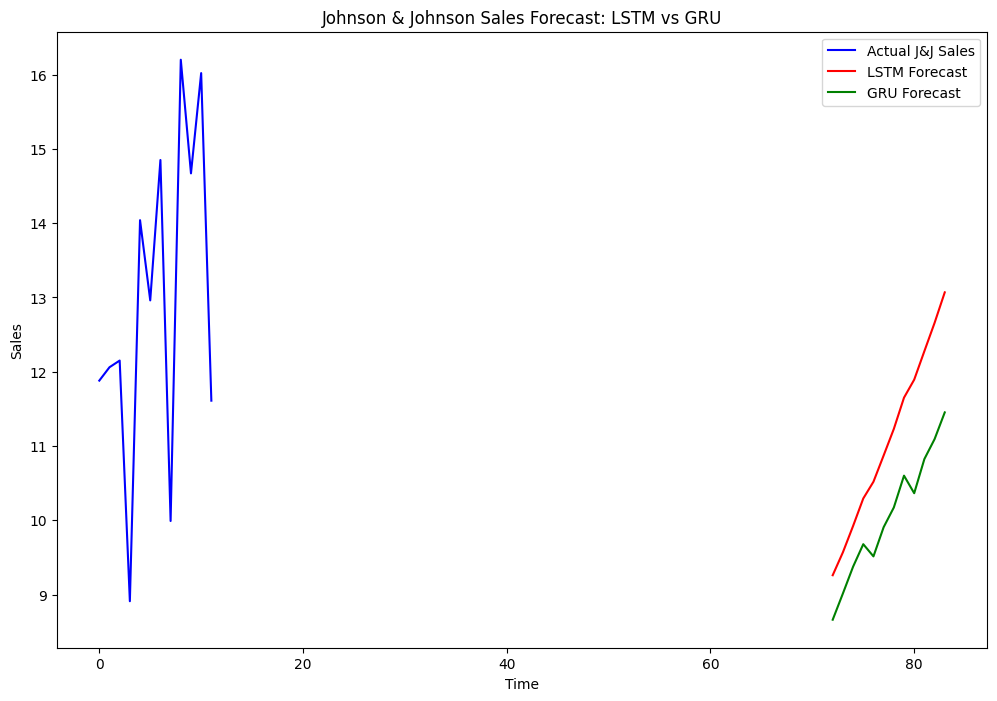

In [43]:
# Plot LSTM and GRU predictions for Johnson & Johnson Sales on the same plot

# Plotting the actual vs predicted values for Johnson & Johnson Sales (LSTM and GRU)
plt.figure(figsize=(12, 8))

# Plot actual Johnson & Johnson sales
plt.plot(data_jj[len(data_jj)-len(y_test_jj):], label='Actual J&J Sales', color='blue')

# Plot LSTM forecast for Johnson & Johnson Sales
plt.plot(np.arange(len(data_jj)-len(y_test_jj), len(data_jj)), predictions_lstm_jj_rescaled, label='LSTM Forecast', color='red')

# Plot GRU forecast for Johnson & Johnson Sales
plt.plot(np.arange(len(data_jj)-len(y_test_jj), len(data_jj)), predictions_gru_jj_rescaled, label='GRU Forecast', color='green')

# Title and labels
plt.title('Johnson & Johnson Sales Forecast: LSTM vs GRU')
plt.xlabel('Time')
plt.ylabel('Sales')
plt.legend()
plt.show()


In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Load the data
jj = pd.read_csv('/content/jj.csv', parse_dates=['date'], index_col='date')
amzn = pd.read_csv('/content/AMZN.csv', parse_dates=['Date'], index_col='Date')

# Define the evaluation function
def evaluate_model_performance(actual, predicted, name="Series"):
    """
    Compute and print evaluation metrics between actual and predicted values.
    """
    actual = actual.loc[predicted.index]  # Ensure index alignment
    mse = mean_squared_error(actual, predicted)
    mae = mean_absolute_error(actual, predicted)
    rmse = np.sqrt(mse)
    r2 = r2_score(actual, predicted)

    print(f"\n📊 Evaluation Metrics for {name}")
    print(f"Mean Absolute Error (MAE):      {mae:.4f}")
    print(f"Mean Squared Error (MSE):       {mse:.4f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
    print(f"R-squared (R²):                 {r2:.4f}")

# Fit ARIMA models (ARMA with d=0)
jj_model = ARIMA(jj['data'], order=(1, 0, 1)).fit()
amzn_model = ARIMA(amzn['Close'], order=(1, 0, 1)).fit()

# Get predictions (in-sample)
jj_pred = jj_model.predict(start=jj.index[0], end=jj.index[-1])
amzn_pred = amzn_model.predict(start=amzn.index[0], end=amzn.index[-1])

# Evaluate predictions
evaluate_model_performance(jj['data'], jj_pred, name="Johnson & Johnson")
evaluate_model_performance(amzn['Close'], amzn_pred, name="Amazon")


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/u


📊 Evaluation Metrics for Johnson & Johnson
Mean Absolute Error (MAE):      0.7940
Mean Squared Error (MSE):       1.7867
Root Mean Squared Error (RMSE): 1.3367
R-squared (R²):                 0.9027

📊 Evaluation Metrics for Amazon
Mean Absolute Error (MAE):      1.9502
Mean Squared Error (MSE):       9.3493
Root Mean Squared Error (RMSE): 3.0577
R-squared (R²):                 0.9923
